# Vehicle Tracking Project
## Udacity CarND
### Josh Smith
### 2017/03/19

## Processing Pipeline

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
import os
import random
import time
import glob
from sklearn.externals import joblib
import pickle

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class VehicleTracker():
    def __init__(self, spatial_size=(8, 8), color_param=([0,1,2], 32), 
                 hog_param=([0,1,2], 9, 8, 2), use_spatial=True, use_color_hist=True, use_hog=True):
        self.spatial_size = spatial_size
        self.color_channels = color_param[0]
        self.color_bins = color_param[1]
        self.hog_channel = hog_param[0]
        self.hog_orient = hog_param[1]
        self.hog_pix = hog_param[2]
        self.hog_cells = hog_param[3]
        self.hog_transform = False
        self.use_spatial = use_spatial
        self.use_color_hist = use_color_hist
        self.use_hog = use_hog
        self.clf_size = (64, 64)
        self.hog_blocks = (self.clf_size[0] // self.hog_pix)-1
        self.heat_map_threshold = 5
        self.ystart = 360
        self.ystop = 670
        self.clf = None
        self.X_scaler = None
        self.heat_history = None
        
    def __str__(self):
        print_string = ("Vehicle Detection Parameters\n" +
                        "Spatial:\t%r\n" % self.use_spatial +
                        "  Spatial Size:\t%s\n" % (self.spatial_size,) +
                        "Color:\t\t%r\n" % self.use_color_hist +
                        "  Channels:\t%s\n" % self.color_channels +
                        "  Bins:\t\t%i\n" % self.color_bins +
                        "HOG:\t\t\t%r\n" % self.use_hog +
                        "  Channel:\t\t%i\n" % self.hog_channel +
                        "  Orientations:\t\t%i\n" % self.hog_orient +
                        "  Pixels per Cell:\t%i\n" % self.hog_pix +
                        "  Cells per Block:\t%i\n" % self.hog_cells +
                        "  Sqrt Transform:\t%r\n" % self.hog_transform +
                        "Window\n" +
                        "  Start:\t%i\n" % self.ystart +
                        "  Stop:\t\t%i\n" % self.ystop +
                        "Classifier:\t" + str(vt.clf)[:9] + "\n" +
                        "  Scaler:\t %s\n" + str(vt.X_scaler)[:14] + 
                        "  Size:\t\t%s\n" % (self.clf_size,) +
                        "  Heat Threshold: %i\n" % self.heat_map_threshold
                       )
        return print_string
    
    def convert_color(self, img, color):
        """ Convert the image from BGR colorspace to something else
        """
        if color == 'RGB':
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif color == 'XYZ':
            return cv2.cvtColor(img, cv2.COLOR_BGR2XYZ)
        elif color == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color == 'LAB':
            return cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif color == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        else:
            return img
        
    def preprocess_image(self, img):
        """ Brightness equalize and Gaussian blur an image
        img -- image to preprocess
        return -- preprocessed image
        """
        # Equalize brightness
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img[:,:,0] = cv2.equalizeHist(img[:,:,0])
        img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
        # Blur
        img = cv2.GaussianBlur(img, (3,3), 0)
        return img
        
    def get_spatial_feature(self, img, color='BGR'):
        """ Extract the spatial feature of an image 
        img -- image to extract spatial feature from
        color -- colorspace to use for extraction
        return -- downsampled spatial feature
        """
        # convert colorspace
        img = self.convert_color(img, color)
        return cv2.resize(img, self.spatial_size).ravel()
    
    def get_color_feature(self, img, color='HLS'):
        """ Color histogram feature of image.
        Channels to extract histogram from is stored in color_channels
        Number of bins in the histogram is stored in color_bins
        img -- image to obtain histogram feature
        color -- colorspace to convert to for extraction
        return -- single, concatenated array of histogram bin values
        """
        # convert colorspace
        img = self.convert_color(img, color)        
        
        # iterate through the color channels and create histogram
        color_features = []
        for channel in self.color_channels:
            channel_hist, _ = np.histogram(img[:,:,channel], bins=self.color_bins, density=False)
            color_features.append(channel_hist)
        if len(self.color_channels) > 1:
            color_features = np.concatenate(color_features)
        return np.ravel(color_features)
    
    def generate_hog(self, img, channel=0, vis=False, color='LAB'):
        """ Extract the HOG feature map without flattening into a feature vector 
        img -- image to extract HOG feature
        channel -- image channel for extraction
        viz -- If True will return the feature size and a HOG visualization image
        color -- Colorspace to use for extraction
        """
        # convert colorspace
        img = self.convert_color(img, color)
            
        if vis == True:
            # Use skimage.hog() to get both features and a visualization
            hog_feature, hog_image = hog(img[:,:,channel], orientations=self.hog_orient, 
                                         pixels_per_cell=(self.hog_pix, self.hog_pix),
                                         cells_per_block=(self.hog_cells, self.hog_cells), 
                                         transform_sqrt=self.hog_transform, 
                                         visualise=vis, feature_vector=False)
            feature_size = len(np.ravel(hog_feature))
            return feature_size, hog_image
        else:
            # Extract just HOG data without flattening for use with sub sample window
            feature = hog(img[:,:,channel], orientations=self.hog_orient, 
                          pixels_per_cell=(self.hog_pix, self.hog_pix),
                          cells_per_block=(self.hog_cells, self.hog_cells), 
                          transform_sqrt=self.hog_transform, 
                          visualise=vis, feature_vector=False)
            return feature
        
    def extract_features(self, image):
        """ Extract features for use in classifier training 
        Stacks the feature vector in the order of Spatial, Color then HOG
        """
        # Extract features
        feature = []
        if self.use_spatial:
            feature.extend(self.get_spatial_feature(image))
        if self.use_color_hist:
            feature.extend(self.get_color_feature(image))
        if self.use_hog:
            for channel in self.hog_channel:
                hog_feature = self.generate_hog(image, channel)
                hog_feature = np.ravel(hog_feature)
                feature.extend(hog_feature)
        return feature
        
    def region_of_interest(self, image, height=None, width=None):
        """ Crop the image to a region of interest 
        """
        img_h, img_w, _ = np.shape(image)
        if not width:
            width = img_w
        if not height:
            y_stop = self.ystop
        else:
            y_stop = self.ystart + height
        
        center = img_w/2
        x_start = np.int(center - width/2)
        x_stop = np.int(x_start + width)
        return image[self.ystart:y_stop, x_start:x_stop, :], x_start
    
    def split_data(self, X, y, test_ratio):
        """ Split the dataset into Train and Test sets
        X -- Feature list
        y -- Label list
        test_ratio -- Ratio to keep for testing
        return -- X_train, X_test, y_train, y_test lists
        """
        # Train test split of data
        rand_state = 121 # set initial random state for consistancy
        X_shuffled, y_shuffled = shuffle(X, y, random_state=rand_state)
        # Split up data into randomized training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, random_state=rand_state)
        return X_train, X_test, y_train, y_test      
    
    def process_training_data(self, image_files):
        """ Process each of the image files and extract feature vector
        Images are brightness equalized, blurred then feature extracted.
        image_files -- List of image file names for processing
        return -- list of extracted features
        """
        features = []
        for index, image in enumerate(image_files):
            # Original Image
            img = cv2.imread(image, 1)
            img = self.preprocess_image(img)
            features.append(self.extract_features(img))
            # show progress
            if index % 250 == 0:
                print('|', end='')
        return features
    
    def train_classifier(self, car_folder, non_car_folder, deep, test_split=0.1):
        """ Train the linear SVM 
        The classifier is stored in the class and exported into a pickle file for use later
        
        car_folder -- [str] Folder where car images reside
        non_car_folder -- [str] Folder where non-car images reside
        deep -- [bool] If true glob will extract from the nexted folders in the top folder
        test_split -- ratio to split for testing
        """
        # Gather training images
        if deep:
            car_files = glob.glob(car_folder + '**/*.png')
            non_car_files = glob.glob(non_car_folder + '**/*.png')
        else:
            car_files = glob.glob(car_folder + '*.png')
            non_car_files = glob.glob(non_car_folder + '*.png')
        print(len(car_files), "car images")
        print(len(non_car_files), "non-car images")
        
        # Generate car feature vector
        print("Constructing car features  ", end='')
        car_features = self.process_training_data(car_files)
        print("  Complete!")
        
        # Generate non-car feature vector
        print("Constructing non-car features  ", end='')       
        non_car_features = self.process_training_data(non_car_files)
        print("  Complete!")
        
        # Combine Car and Non-Car features in to a single dataset
        X_raw = np.vstack((car_features, non_car_features)).astype(np.float64)
        
        # Construct label vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
        
        # Normalize with scalar
        self.X_scaler = StandardScaler().fit(X_raw)
        X = self.X_scaler.transform(X_raw)
        print("Normalization Complete")
        
        # Split Data into Train and Test
        X_train, X_test, y_train, y_test = self.split_data(X, y, test_split)
        print("Data Split Complete\n  Train: %i\n  Test: %i" % (len(X_train), len(X_test)))
             
        # Create Classifier
        self.clf = LinearSVC()
        
        # Train Classifier
        print('Feature vector length:', len(X_train[0]))
        # Check the training time for the SVC
        print("Starting Classifier Fit")
        t=time.time()
        self.clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test accuracy of classifier = ', round(self.clf.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('Classifier predictions:\t', self.clf.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with classifier.')
        
        # save classifier
        clf_file = {"classifier": self.clf,
                   "scaler": self.X_scaler}
        joblib.dump(clf_file, 'vehicle_classifier.pkl') 
        
    def load_classifier(self):
        """ load the classifier from the saved pickle file 
        Loads the classifier and the feature scalar into the class
        """
        clf_file = joblib.load('vehicle_classifier.pkl')
        self.clf = clf_file["classifier"]
        self.X_scaler = clf_file["scaler"]
        if self.clf == None or self.X_scaler == None:
            print("Load Failed")
        else:
            print("Classifier Loaded")
    
    def test_window(self, image, hog_maps, min_corner):
        """ Predict if there is a car in the passed image and window location 
        image -- region of interest image
        hog_maps -- stack of HOG feature maps to subsample
        min_corner -- minimum value corner of the test window to test
        return -- True if a car is detected, False otherwise.
        """
        # Sub sample image and resize for classifer
        image_window = np.asarray(min_corner)*(self.hog_pix)
        img_window = image[image_window[1]:image_window[1]+self.clf_size[1], image_window[0]:image_window[0]+self.clf_size[0]]

        # Extract features
        feature = []
        # Extract spatial feature
        if self.use_spatial:
            spatial_feature = self.get_spatial_feature(img_window)
            feature.extend(spatial_feature)
        # Extract color histogram feature
        if self.use_color_hist:
            color_feature = self.get_color_feature(img_window) 
            feature.extend(color_feature)
        # Extract hog sub sample feature
        if self.use_hog:
            # Sub sample hog map and resize for classifier
            for hog_map in hog_maps:
                hog_window = hog_map[min_corner[1]:min_corner[1]+self.hog_blocks, min_corner[0]:min_corner[0]+self.hog_blocks]
                # Flatten hog sub sample
                hog_feature = np.ravel(hog_window)
                feature.extend(hog_feature)
        
        # Apply standard scalar to feature
        feature = np.asarray(feature).astype(np.float64)
        feature = feature.reshape(1, -1)
        scaled_feature = self.X_scaler.transform(feature)        
        # Determine sample's distance from decision boundary
        distance = self.clf.decision_function(scaled_feature)
        # Only return samples with high confidnce
        if distance > 1.0:
            return True
        else:
            return False
    
    def search_image(self, image, show_all=False, size_index = -1):
        """ Sliding window search implementation
        Slide the window sizes in window_sizes over the region of interested defined
        in y_starts and y_stops below.  Windows are passed to test_window() for detection.
        image -- full image to search
        step_size -- number of blocks to step in the search
        show_all -- when True all of the search windows are shown
        size_index -- full search when size_index is negative.  
                      Otherwise specific search sizes can be tested from the window_sizes list
        return -- list of window corners with detected cars        
        """
        window_sizes = [112, 98, 64]
        y_starts = [370, 379, 396]
        y_stops = [650, 625, 500]
        x_widths = [1280, 1280, 850]
        step_sizes = [2, 2, 1]
        
        if size_index >= 0:
            size_index = size_index%len(window_sizes)
            window_sizes = [window_sizes[size_index]]
            y_starts = [y_starts[size_index]]
            y_stops = [y_stops[size_index]]
            x_widths = [x_widths[size_index]]
            step_sizes = [step_sizes[size_index]]
        
        # List to store windows with cars
        windows_with_cars = []
        probabilities = []
        
        for window_size, y_start, y_stop, x_width, step_size in zip(window_sizes, y_starts, y_stops, x_widths, step_sizes):
            # Crop to region of interest
            x_start = 640 - x_width//2
            x_stop = 640 + x_width//2
            roi_image = image[y_start:y_stop,x_start:x_stop,:]
            img_shape = np.shape(roi_image)
            
            # calculate scaling and resize image
            scale = window_size/self.clf_size[0]
            if scale != 1.0:
                roi_image = cv2.resize(roi_image, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
            hog_maps = []
            for channel in self.hog_channel:
                hog_maps.append(self.generate_hog(roi_image, channel))
            search_height, search_width, _ = np.shape(roi_image)
            
            # rescale to blocks
            search_height = search_height//self.hog_pix
            search_width = search_width//self.hog_pix
            
            # slide through the region of interest and test each window for a car using the classifier
            top = 0
            while top+self.hog_blocks < search_height:
                left = 0
                while left+self.hog_blocks < search_width:
                    min_corner = (left, top)
                    prediction = self.test_window(roi_image, hog_maps, min_corner)
                    if show_all or prediction == 1:
                        # Adjust the postion of the window from the coordinates of the cropped
                        # image to the coordinates of the master image
                        x_pos = np.int(left*self.hog_pix*scale+x_start)
                        y_pos = np.int(top*self.hog_pix*scale+y_start)
                        adj_size = np.int(self.clf_size[0]*scale)
                        adj_window = [(x_pos, y_pos), (x_pos+adj_size, y_pos+adj_size)]
                        windows_with_cars.append(adj_window)
                    left += step_size
                top += step_size
        return windows_with_cars
    
    def check_window(self, window):
        """ Check if the detected car bounding box looks valid
        test for a large aspect ratio and minimum size
        window -- corner points of detected car
        returns -- boolean if window is valid
        """
        width = abs(window[1][0] - window[0][0]) 
        height = abs(window[1][1] - window[0][1]) 
        aspect_ratio = max(width, height)/min(width, height)
        if width*height > 3000 and aspect_ratio < 3:
            return True
        else:
            return False
        
    def generate_heatmap(self, image, windows_with_cars):
        """ Generate a heatmap from a list of active windows 
        image -- used to create heatmap of same size
        windows_with_cars -- active windows to convert to heatmap
        return -- heatmap image
        """
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        for window in windows_with_cars:
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
        return heatmap
    
    def generate_prob_heatmap(self, image, windows, probabilities):
        """ Generate a heatmap from a list of active windows 
        image -- used to create heatmap of same size
        windows_with_cars -- active windows to convert to heatmap
        return -- heatmap image
        """
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        for window, prob in zip(windows, probabilities):
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += prob
        return heatmap
    
    def threshold_heatmap(self, heatmap):
        """ threshold heatmap using standard heat_map_threshold 
        heatmap -- heatmap to threshold
        return -- heatmap with values below threshold squashed to zero
        """
        heatmap[heatmap < self.heat_map_threshold] = 0
        return heatmap
    
    def bbox_cars(self, image, verbose=False):
        """ Generate bounding boxes from heatmap and draw on image
        image -- image to find and bounding box cars
        return -- original image with bounding boxes drawn
        """
        t=time.time()
        # Apply standard preprocessing to image
        pp_image = self.preprocess_image(image)
        # Find windows with cars in them
        windows_with_cars = self.search_image(image)
        # Generate heatmap for this frame
        heatmap = self.generate_heatmap(image, windows_with_cars)
      
        # Construct a history of the heatmaps
        history = self.heat_history
        if history == None:
            history = []
            for _ in range(15):
                history.append(np.zeros_like(heatmap))

        # add new heatmap to history
        history.append(heatmap)
        
        # remove old heatmaps
        while len(history) > 15:
            history.pop(0)
            
        # Decay history heat map by average bluring
        history = [cv2.blur(hist_map, (17,17)) for hist_map in history]
        # Average the history of decaying heatmaps and use as current heatmap
        heatmap = np.sum(history, axis=0)
        heatmap = cv2.blur(heatmap, (17,17))
        # Threshold the heatmap       
        heatmap = self.threshold_heatmap(heatmap)
        # Update the historic map
        self.heat_history = history
        
        label_cars = label(heatmap)
        if verbose:
            print(len(label_cars[1]), "found!")
            print(label_cars)
        for car_number in range(1, label_cars[1]+1):
            # Find pixels with each car_number label value
            nonzero = (label_cars[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # check if the window looks resonable
            if self.check_window(bbox):
                # Draw the box on the image
                cv2.rectangle(image, bbox[0], bbox[1], (0,255,0), 6)
        # Return the image
        t2=time.time()
        frames_per_second = 1.0/(t2-t)
        cv2.putText(image, "Heatmap Max%7.0f" % np.max(heatmap), (25, 50), 0, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(image, "Frame Rate%7.3f" % frames_per_second, (25, 75), 0, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        return image
    
    def process_video(self, video_file):
        """ Simple function for processing video
        video_file -- file path to video file
        file saved into output_video folder and prefixed with "processed_"
        """
        self.heat_history = None
        self.heat_map_threshold = 15
        clip1 = VideoFileClip(video_file)
        project_clip = clip1.fl_image(self.bbox_cars)
        project_clip.write_videofile('output_videos/processed_'+video_file, audio=False)
        
        
def get_random_car_image(folder='vehicles/KITTI_extracted/'):
    img_file = random.sample(os.listdir(folder), 1)
    return cv2.imread(folder + img_file[0], 1)

def get_random_non_car_image(folder='non-vehicles/GTI/'):
    img_file = random.sample(os.listdir(folder), 1)
    return cv2.imread(folder + img_file[0], 1)

def compare_images(images, titles, axis='off'):
    """ Create figure from a list of images
    images -- [[image1, image2], [image3, image4]] n X m array of images arranged as displayed
    titles -- list of titles for each image
    """
    rows = len(images)
    cols = len(images[0])
    index = 1
    img_shape = np.shape(images[0][0])
    figure = plt.figure(figsize=(4*cols,3*rows))
    for row in images:
        for image in row:
            plt.subplot(rows, cols, index)
            plt.title(titles[index-1])
            plt.axis(axis)
            plt.imshow(image, cmap='gray')
            index += 1
    plt.show()
    
def read_files(folder, file_type='jpg', deep=False):
    if deep:
        images = glob.glob(folder+'**/*.'+file_type)
    else:
        images = glob.glob(folder+'*'+file_type)
    return images

def rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Explore Colorspace on Color and Spatial Features 

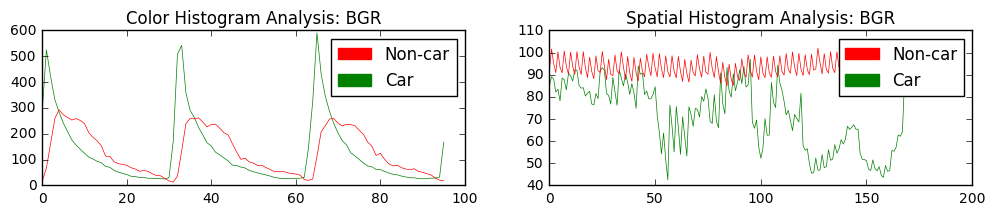

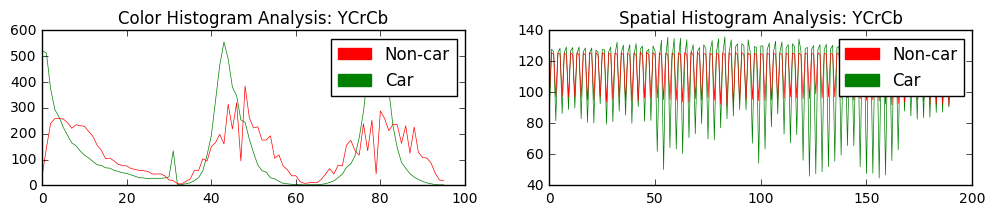

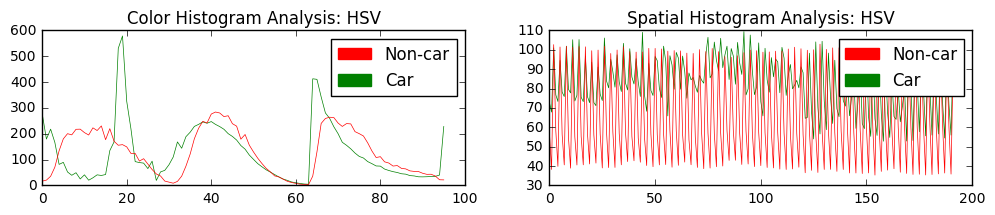

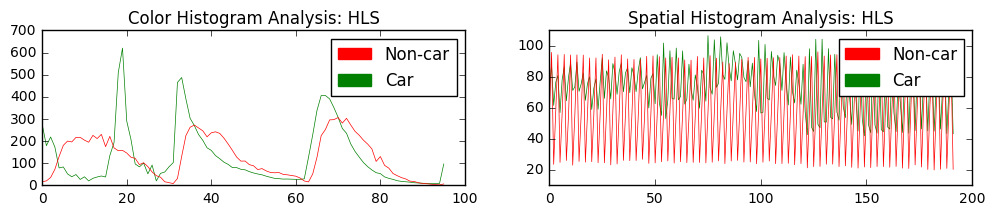

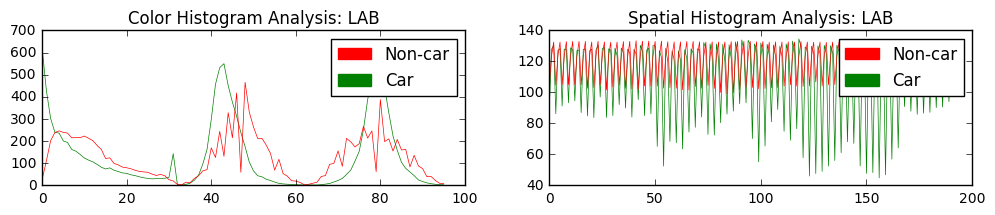

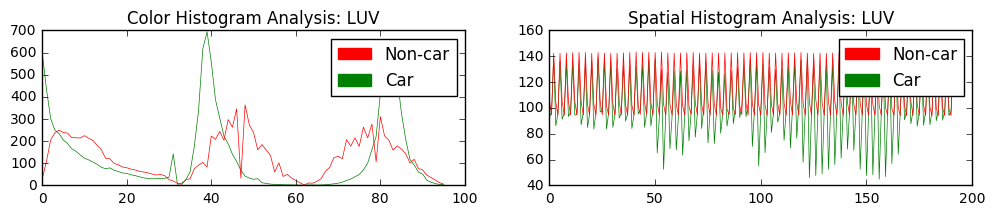

In [2]:
vt = VehicleTracker()

# Colorspaces to test
colors = ['BGR', 'YCrCb', 'HSV', 'HLS', 'LAB', 'LUV', 'YUV']
vt.color_channels = [0,1,2]
test_images = []
# Generate samples
car_images = []
non_car_images=[]
for _ in range(200):
    car_images.append(get_random_car_image())
    non_car_images.append(get_random_non_car_image())
test_images = [car_images, non_car_images]
plot_colors = ['g', 'r']
red_patch = mpatches.Patch(color='red', label='Non-car')
green_patch = mpatches.Patch(color='green', label='Car')
for color in colors:
    fig = plt.figure(figsize=(12,2))
    for group_id, image_group in enumerate(test_images):
        color_hist = []
        spatial_hist = []
        hog_hist = []
        for index, image in enumerate(image_group):
            color_hist.append(vt.get_color_feature(image, color))
            spatial_hist.append(vt.get_spatial_feature(image, color))
        plt.subplot(1,2,1)
        plt.plot(np.mean(color_hist, axis=0), color=plot_colors[group_id], linewidth=0.5) 
        plt.title("Color Histogram Analysis: %s" % color)
        plt.legend(handles=[red_patch, green_patch])
        plt.subplot(1,2,2)
        plt.plot(np.mean(spatial_hist, axis=0), color=plot_colors[group_id], linewidth=0.5) 
        plt.title("Spatial Histogram Analysis: %s" % color)
        plt.legend(handles=[red_patch, green_patch])
    plt.show()

## Explore HOG Orientation and Cell Size Parameters

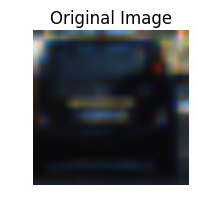

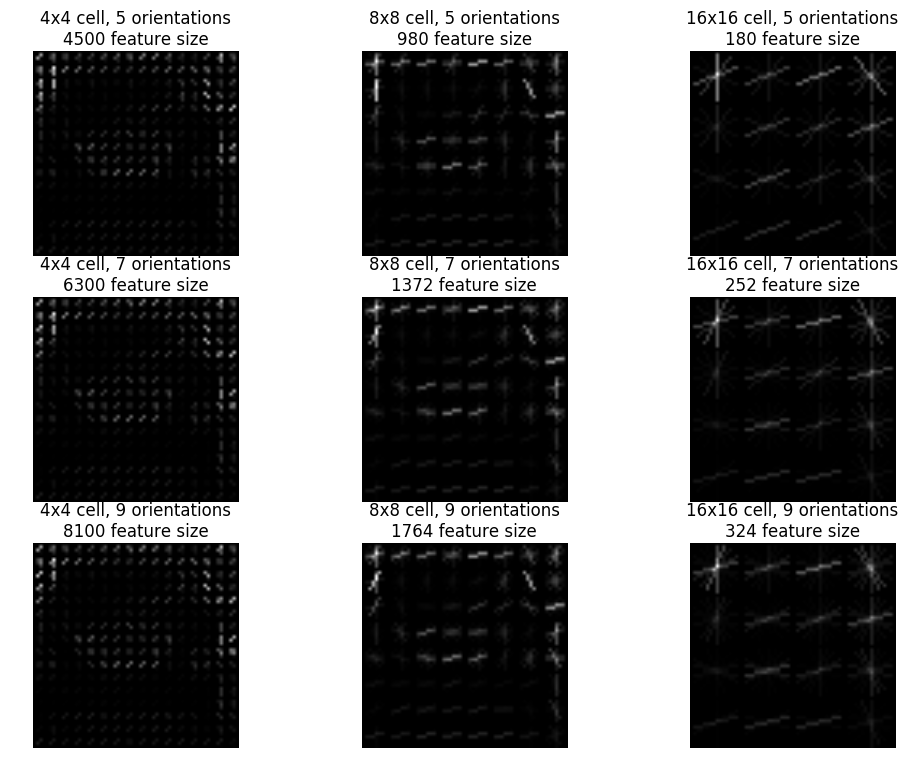

In [3]:
vt = VehicleTracker()
hog_compare_images = []
hog_compare_titles = []

# hog cell sizes to examine
trial_pix_per_cell = [4, 8, 16]
trial_orients = [5, 7, 9]

image = get_random_car_image()

plt.figure(figsize=(5,2))
plt.imshow(rgb(image))
plt.title("Original Image")
plt.axis('off')
plt.show()

vt.hog_channels = [0]
vt.hog_cells = 2

for orients in trial_orients:
    vt.hog_orient = orients
    row = []
    for pix in trial_pix_per_cell:
        vt.hog_pix = pix
        hog_size, hog_img = vt.generate_hog(image, vis=True)
        row.append(hog_img)
        hog_compare_titles.append("%ix%i cell, %i orientations\n%i feature size" % 
                                  (vt.hog_pix, vt.hog_pix, vt.hog_orient, hog_size))
    hog_compare_images.append(row)
compare_images(hog_compare_images, hog_compare_titles)

## Explore HOG Colorspace

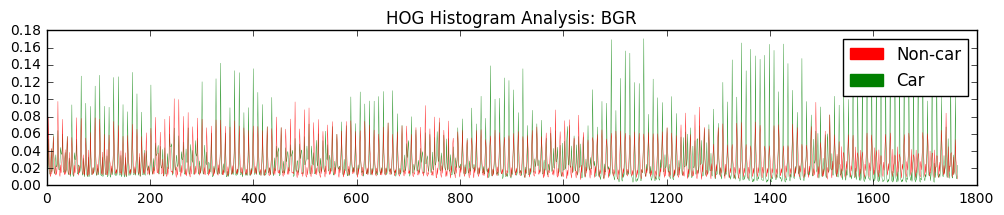

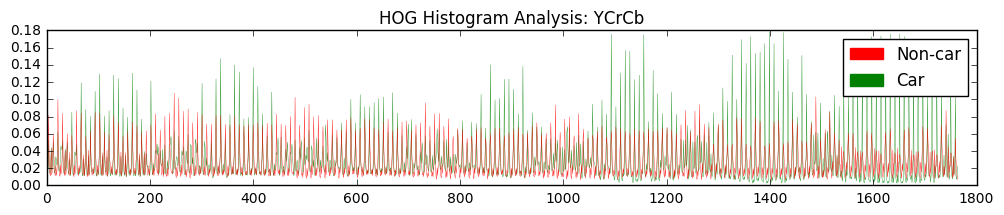

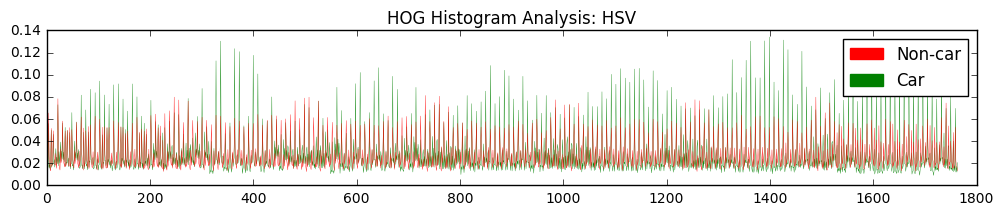

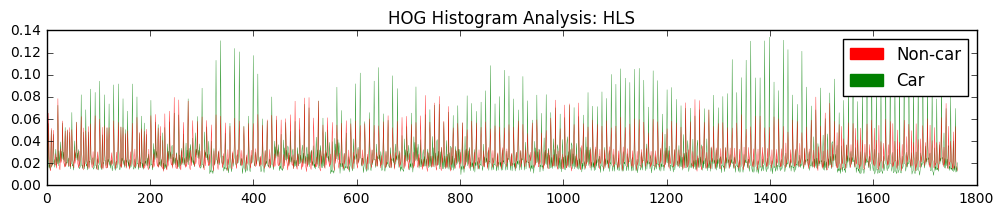

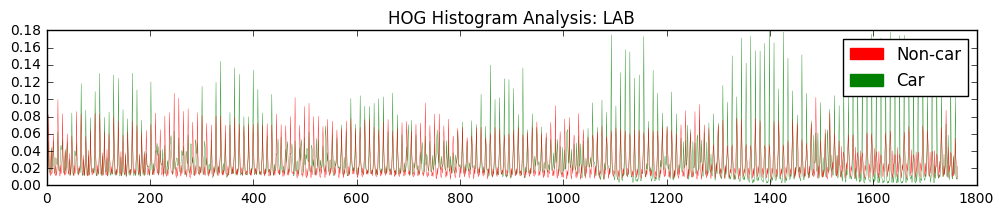

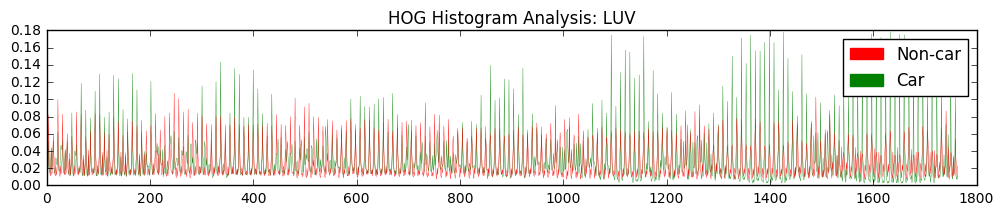

In [4]:
vt = VehicleTracker()

colors = ['BGR', 'YCrCb', 'HSV', 'HLS', 'LAB', 'LUV', 'YUV']
test_images = []
# Generate samples
car_images = []
non_car_images=[]
for _ in range(200):
    car_images.append(get_random_car_image())
    non_car_images.append(get_random_non_car_image())
test_images = [car_images, non_car_images]
plot_colors = ['g', 'r']
red_patch = mpatches.Patch(color='red', label='Non-car')
green_patch = mpatches.Patch(color='green', label='Car')
for color in colors:
    fig = plt.figure(figsize=(12,2))
    for group_id, image_group in enumerate(test_images):
        hog_hist = []
        for index, image in enumerate(image_group):
            hog_hist.append(vt.generate_hog(image, vis=False, color=color).ravel())
        plt.plot(np.mean(hog_hist, axis=0), color=plot_colors[group_id], linewidth=0.25) 
        plt.title("HOG Histogram Analysis: %s" % color)
        plt.legend(handles=[red_patch, green_patch])
    plt.show()

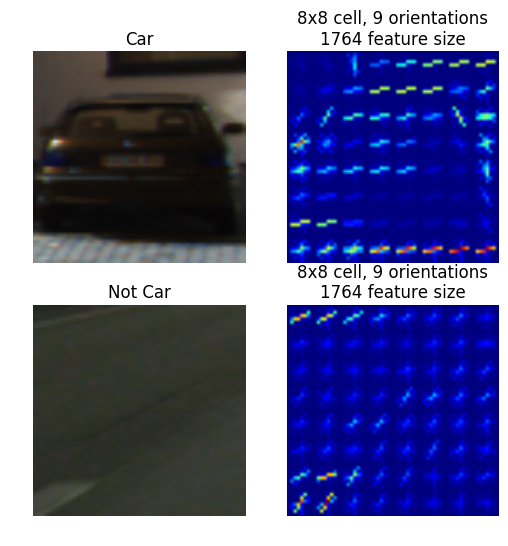

In [15]:
vt = VehicleTracker()
hog_compare_images = []
hog_compare_titles = []

car = get_random_car_image()
not_car = get_random_non_car_image()
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.title("Car")
plt.axis('off')
plt.imshow(car)
hog_size, hog_img = vt.generate_hog(car, vis=True)
plt.subplot(222)
plt.axis('off')
plt.imshow(hog_img)
plt.title("%ix%i cell, %i orientations\n%i feature size" % 
                                  (vt.hog_pix, vt.hog_pix, vt.hog_orient, hog_size))
plt.subplot(223)
plt.axis('off')
plt.title("Not Car")
plt.imshow(not_car)
hog_size, hog_img = vt.generate_hog(not_car, vis=True)
plt.subplot(224)
plt.axis('off')
plt.imshow(hog_img)
plt.title("%ix%i cell, %i orientations\n%i feature size" % 
                                  (vt.hog_pix, vt.hog_pix, vt.hog_orient, hog_size))
plt.show()

## Training Set Preprocessing
Training images are brigtness equalized and Gaussian blurred.
This was a major improvement on false positives.

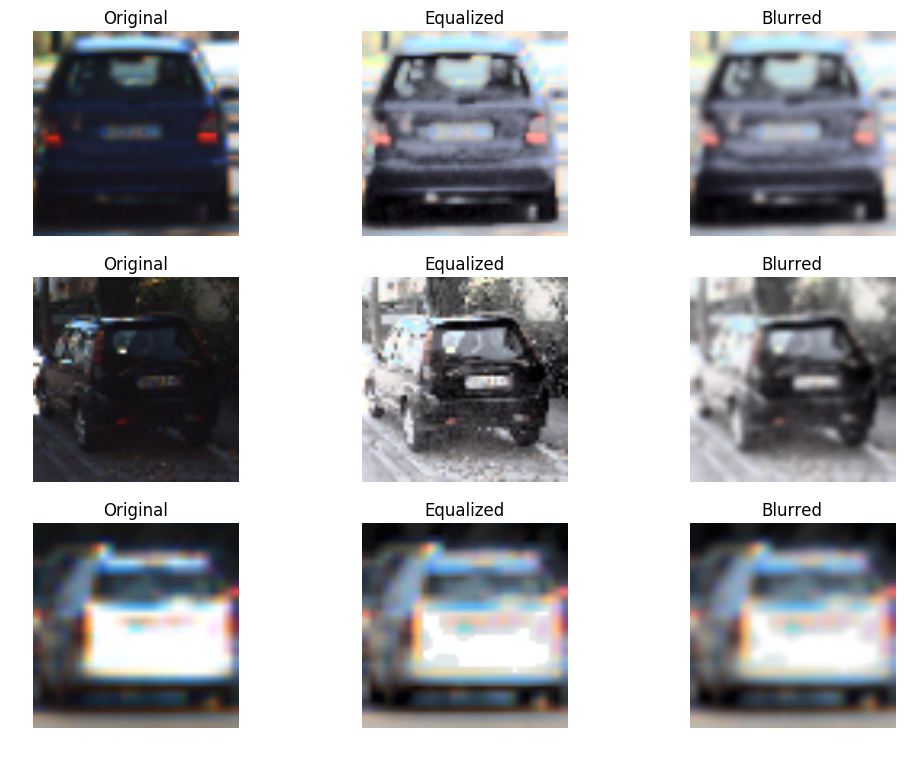

In [147]:
images = []
titles = []
for _ in range(3):
    image_row = []
    image = get_random_car_image()
    image_row.append(rgb(image))
    # Equalize
    image = vt.equalize(image)
    image_row.append(rgb(image))
    # Blur
    image = cv2.GaussianBlur(image, (3,3), 0)
    image_row.append(rgb(image))
    images.append(image_row)
    titles.extend(['Original', 'Equalized', 'Blurred'])
compare_images(images, titles)

## Train Classifier
Preprocess images and extract feature vectors.
Fit scalar to the constructed feature vectors.
Split training data into train and test sets.
Train classifier.
Test classifier on test set.

8794 car images
8987 non-car images
Constructing car features  ||||||||||||||||||||||||||||||||||||  Complete!
Constructing non-car features  ||||||||||||||||||||||||||||||||||||  Complete!
Normalization Complete
Data Split Complete
  Train: 16002
  Test: 1779
Feature vector length: 5580
Starting Classifier Fit
8.32 Seconds to train SVC...
Test accuracy of classifier =  0.9899
Classifier predictions:	 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:	 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.017 seconds to predict 10 labels with classifier.


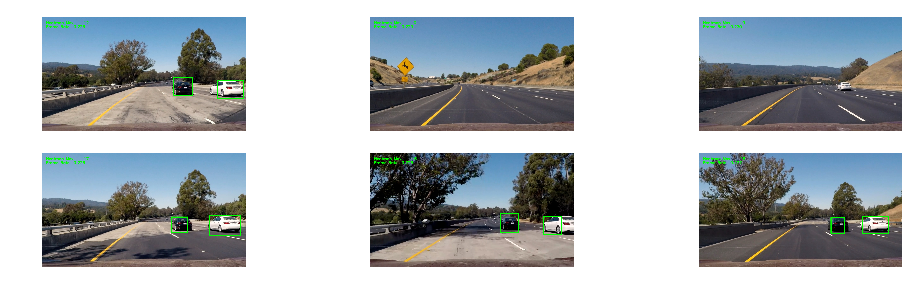

In [25]:
vt = VehicleTracker()
# Train Classifier
vt.train_classifier('vehicles/', 'non-vehicles/', deep=True)

# Test Classifier on full test images
images = glob.glob('test_images/*.jpg')
figure = plt.figure(figsize=(12,5))
i = 1
for image in images:
    image = cv2.imread(image, 1)
    vt.heat_history = None
    boxed_image = vt.bbox_cars(image)
    plt.subplot(len(images)//3+1,3,i)
    plt.imshow(rgb(boxed_image))
    plt.axis('off')
    i += 1
plt.show()

## Take a look at the feature sizes

In [26]:
vt = VehicleTracker()
vt.load_classifier()

image = get_random_car_image()
color_feature_size = len(vt.get_color_feature(image))
spatial_feature_size = len(vt.get_spatial_feature(image))
hog_feature_size =len(np.ravel(vt.generate_hog(image)))
feature_size = len(vt.extract_features(image))

print("Color feature size:   ", color_feature_size)
print("Spatial feature size: ", spatial_feature_size)
print("HOG size per channel: ", hog_feature_size)
print("Feature size:         ", feature_size)

Classifier Loaded
Color feature size:    96
Spatial feature size:  192
HOG size per channel:  1764
Feature size:          5580


## Explore the classifier predictions

Classifier Loaded


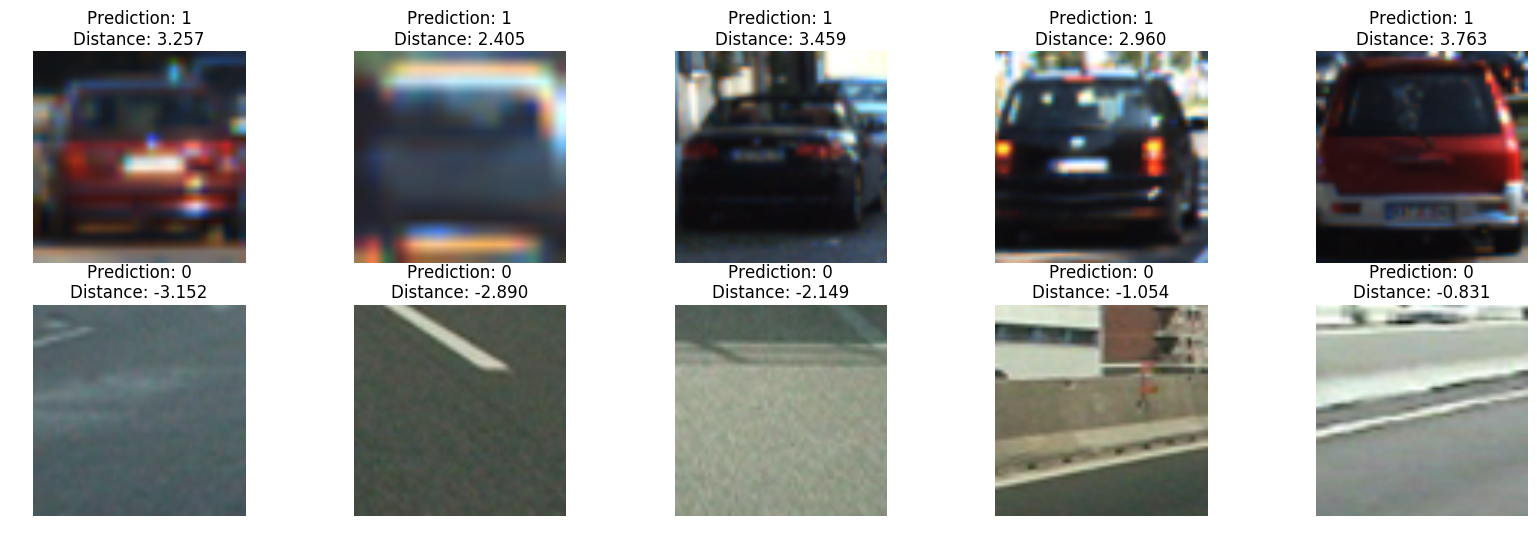

In [28]:
# Explore the predictions of the classifier
vt = VehicleTracker()
vt.load_classifier()

cars = []
non_cars = []
car_labels = []
non_car_labels = []
for _ in range(5):
    # Process Cars
    image = get_random_car_image()
    feature = vt.extract_features(image)
    feature = vt.X_scaler.transform(feature)
    prediction = vt.clf.predict(feature)[0]
    distance = vt.clf.decision_function(feature)
    cars.append(rgb(image))
    car_labels.append(str("Prediction: %i\nDistance: %4.3f" % (prediction, distance)))
    # Process Non-Car
    image = get_random_non_car_image()
    feature = vt.extract_features(image)
    feature = vt.X_scaler.transform(feature)
    prediction = vt.clf.predict(feature)[0]
    distance = vt.clf.decision_function(feature)
    non_cars.append(rgb(image))
    non_car_labels.append(str("Prediction: %i\nDistance: %4.3f" % (prediction, distance)))
titles = car_labels + non_car_labels
compare_images([cars, non_cars], titles)

## Sliding Window Search
The sliding window search is done at several different window scales.  Each window size is shown with its corresponding search window.  Activated windows are shown when a car is detected by the classifier.

Classifier Loaded
1231 windows searched per image


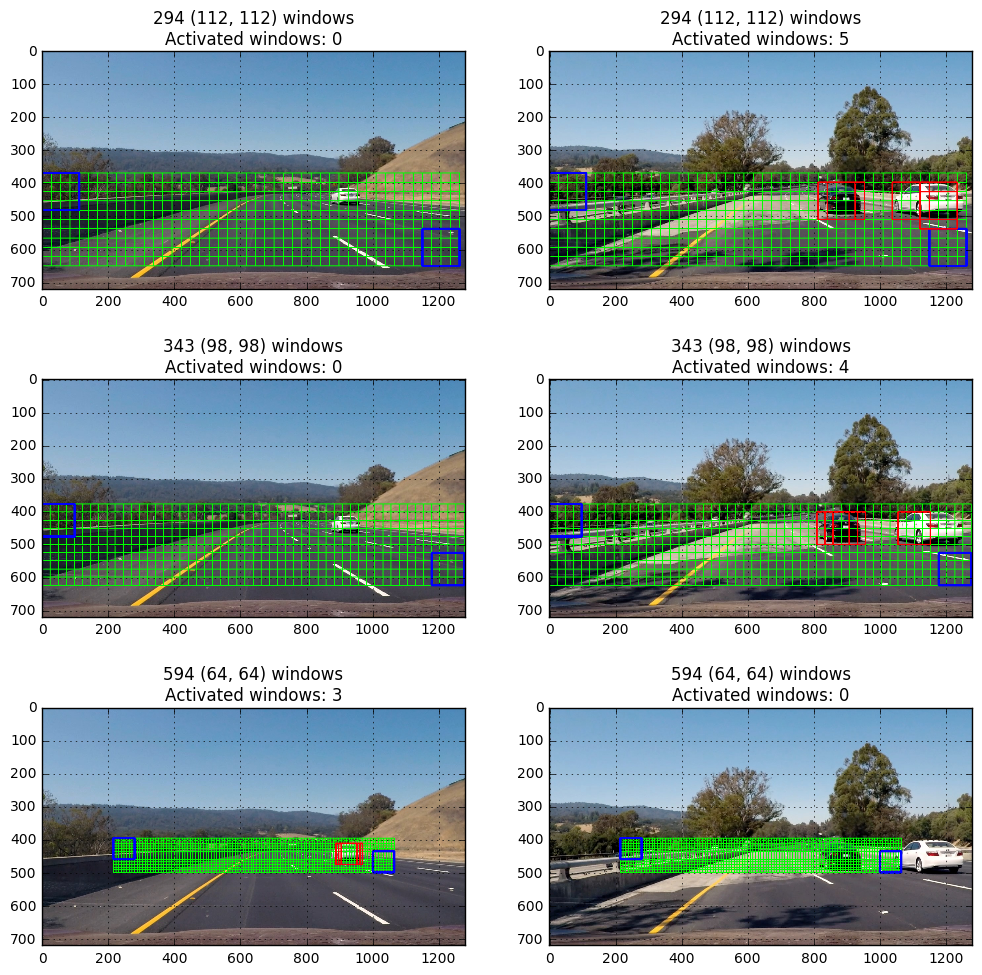

In [45]:
vt = VehicleTracker()
vt.load_classifier()

test_images = glob.glob('test_images/*.jpg')
num_images = len(test_images[2:4])
total_searched_windows = 0
window_size_index = [0, 1, 2]
fig, ax = plt.subplots(len(window_size_index), num_images, figsize=(12,12))
for index, image in enumerate(test_images[2:4]):
    image = cv2.imread(image, 1)
    for win_index in window_size_index:
        # Show Search Grid
        car_windows = vt.search_image(image, show_all=True, size_index = win_index)
        window_size = car_windows[0][1][0]-car_windows[0][0][0]
        window_count = len(car_windows)
        total_searched_windows += window_count
        image_search = np.copy(image)
        for bbox in car_windows:
            cv2.rectangle(image_search, bbox[0], bbox[1], (0,255,0), 2)
        
        # Highlight window size
        cv2.rectangle(image_search, car_windows[0][0], car_windows[0][1], (255,0,0), 6)
        cv2.rectangle(image_search, car_windows[-1][0], car_windows[-1][1], (255,0,0), 6)
        
        # Show activated windows
        car_windows = vt.search_image(image, show_all=False, size_index = win_index)
        for bbox in car_windows:
            cv2.rectangle(image_search, bbox[0], bbox[1], (0,0,255), 4)
        
        # Display grid search results
        ax[win_index, index].imshow(rgb(image_search))
        ax[win_index, index].set_title("%i (%i, %i) windows\nActivated windows: %i" % (window_count, window_size,window_size, len(car_windows)))
        ax[win_index, index].grid(True)
print("%i windows searched per image" % (total_searched_windows//num_images))
plt.show()

## Bounding Box Creation
First the sliding window search is done which shows the windows where are car was detected.  These active windows are then used to create a heatmp by adding one to the area within the window.  This results in a heatmap that shows high values in areas with a high number of activated windows.  The heatmap can then be manipulated in much the same way as a image.  The heatmap is blured to blend the detected areas into uniform patches.  A threshold is then applied to the heatmap setting all areas below the threshold to zero.  The result is distinct blobs in the heatmap which should correspond to positions of cars.  The cars are then detected using the `scipy.ndimage.measurements.label()` function.  This turns each blob into a indexed value which can then be used to create bounding boxes.

Classifier Loaded


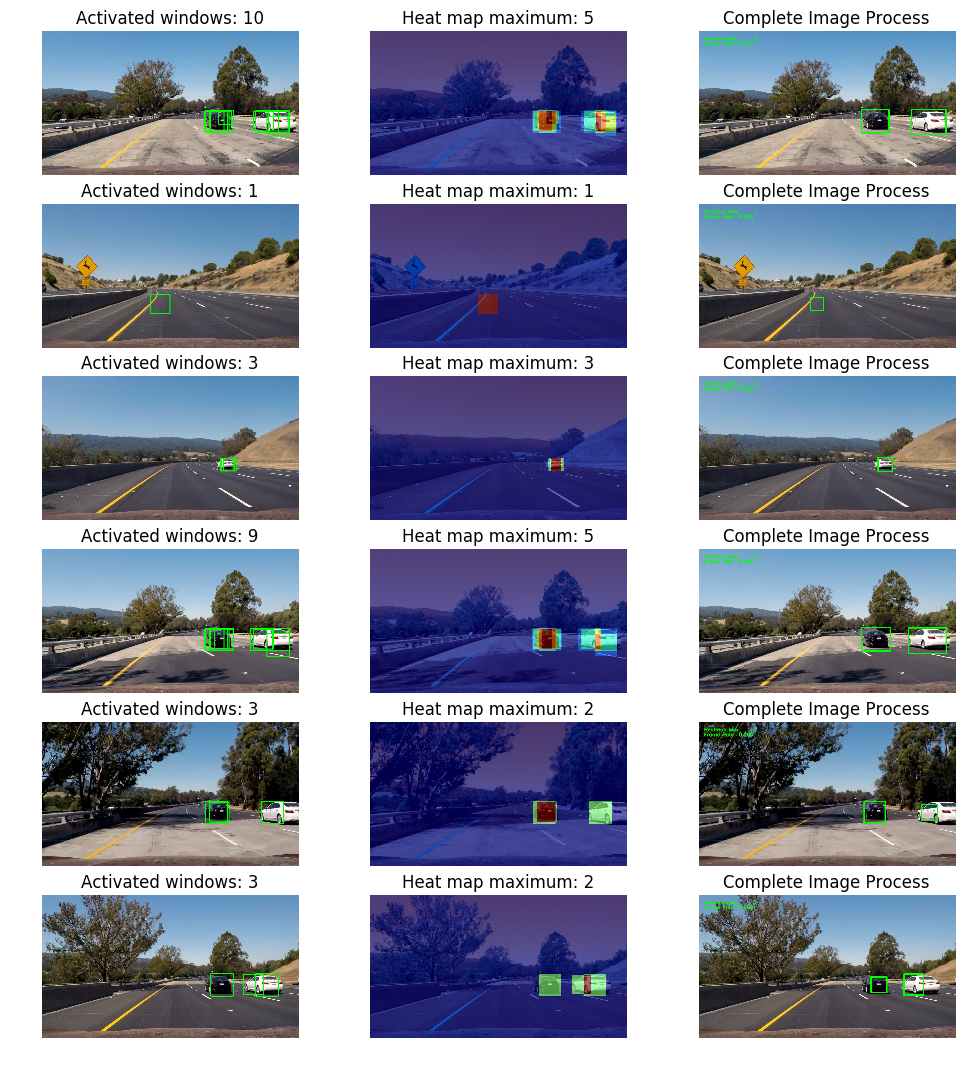

In [46]:
vt = VehicleTracker()
vt.load_classifier()

vt.heat_map_threshold = 1
test_images = glob.glob('test_images/*.jpg')
num_images = len(test_images)
fig, ax = plt.subplots(num_images, 3, figsize=(12,13))
for index, image in enumerate(test_images):
    image = cv2.imread(image, 1)

    # Scan for cars
    car_windows = vt.search_image(image, show_all=False, size_index = -1)

    # draw car windows
    image_search = np.copy(image)
    for bbox in car_windows:
        cv2.rectangle(image_search, bbox[0], bbox[1], (0,255,0), 4)

    # Show windows with cars detected
    ax[index, 0].imshow(rgb(image_search))
    ax[index, 0].set_title("Activated windows: %i" % len(car_windows))
    ax[index, 0].axis('off')
    
    # Generate Heatmap
    heatmap = vt.generate_heatmap(image, car_windows)
    
    # Show generated heatmap
    ax[index, 1].imshow(heatmap, cmap = 'jet')
    ax[index, 1].imshow(image, alpha = 0.4)
    ax[index, 1].set_title("Heat map maximum: %i" % np.max(heatmap))
    ax[index, 1].axis('off')

    # Run the full bounding box car function
    vt.heat_history = None
    boxed = vt.bbox_cars(image)
    ax[index, 2].imshow(rgb(boxed))
    ax[index, 2].set_title("Complete Image Process")
    ax[index, 2].axis('off')
plt.show()

## Video Processing

### Test Video

In [47]:
vt = VehicleTracker()
vt.load_classifier()
project_video = 'test_video.mp4'
vt.process_video(project_video)

Classifier Loaded
[MoviePy] >>>> Building video output_videos/processed_test_video.mp4
[MoviePy] Writing video output_videos/processed_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:53<00:04,  4.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed_test_video.mp4 



In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/processed_'+project_video))

### Project Video

In [49]:
project_video = 'project_video.mp4'
vt.process_video(project_video)

[MoviePy] >>>> Building video output_videos/processed_project_video.mp4
[MoviePy] Writing video output_videos/processed_project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:33:22<00:04,  4.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed_project_video.mp4 



In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/processed_'+project_video))

## Heatmap Decay
Heatmaps from each frame are captured and stored.  After each frame the old heatmaps are blurred then added together to create the heatmap for the current frame.  Here are the heatmaps as they decay.  The newer frames show a sharper heatmap while th older frames become more and more dispersed.

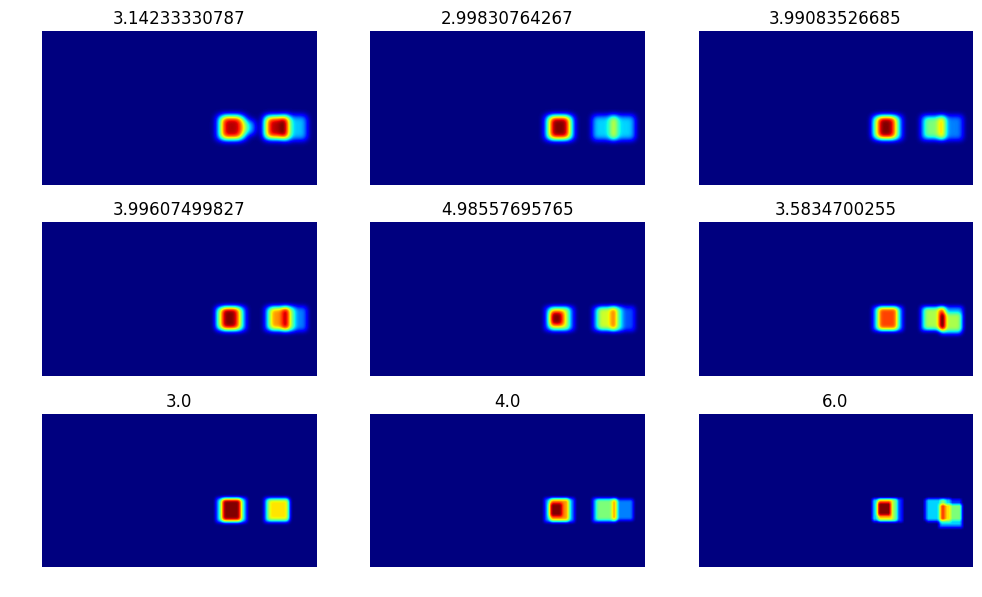

In [40]:
testing_history = vt.heat_history
fig = plt.figure(figsize=(12,7))
for index, heatmap in enumerate(testing_history[-9:]):
    plt.subplot(3, 3, index+1)
    plt.imshow(heatmap, cmap='jet')
#     plt.title("Heatmap Frame %i" % (index - len(testing_history)+5))
    plt.title(np.max(heatmap))
    plt.axis('off')
plt.show()

## Combining Heatmaps
The decaying heatmaps from the last 10 frames are added together to create the current frame heatmap.  after they are added together the heatmap is blured to blend the composite heatmap.  Then the threshold is applied to give the distict blobs to then label.

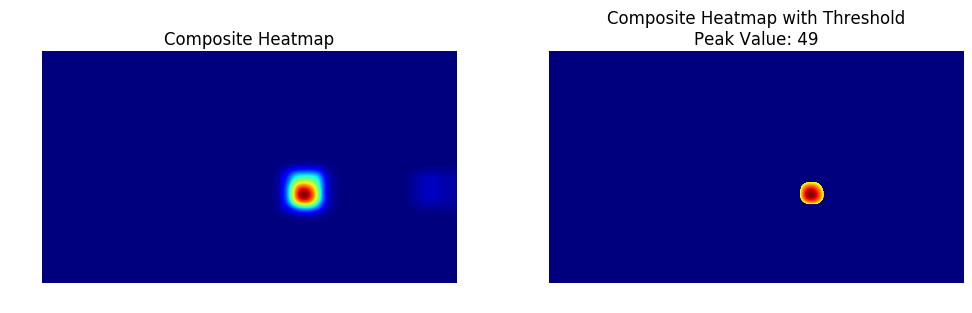

In [23]:
fig = plt.figure(figsize=(12,3))
total_heat = np.sum(testing_history, axis=0)
total_heat = cv2.blur(total_heat, (23,23))
plt.subplot(121)
plt.imshow(total_heat, cmap='jet')
plt.title("Composite Heatmap")
plt.axis('off')
clip = total_heat
clip[clip < 30] = 0
# clip = cv2.blur(clip,(64,64))
plt.subplot(122)
plt.imshow(clip, cmap='jet')
plt.title("Composite Heatmap with Threshold\nPeak Value: %i" % np.max(clip))
plt.axis('off')
plt.show()

## Heatmap Decay
Here is a single frame heatmap as it decays throug time.  The scaling is maintained to better show the reduction in intensity and dispersion of the hot spots.

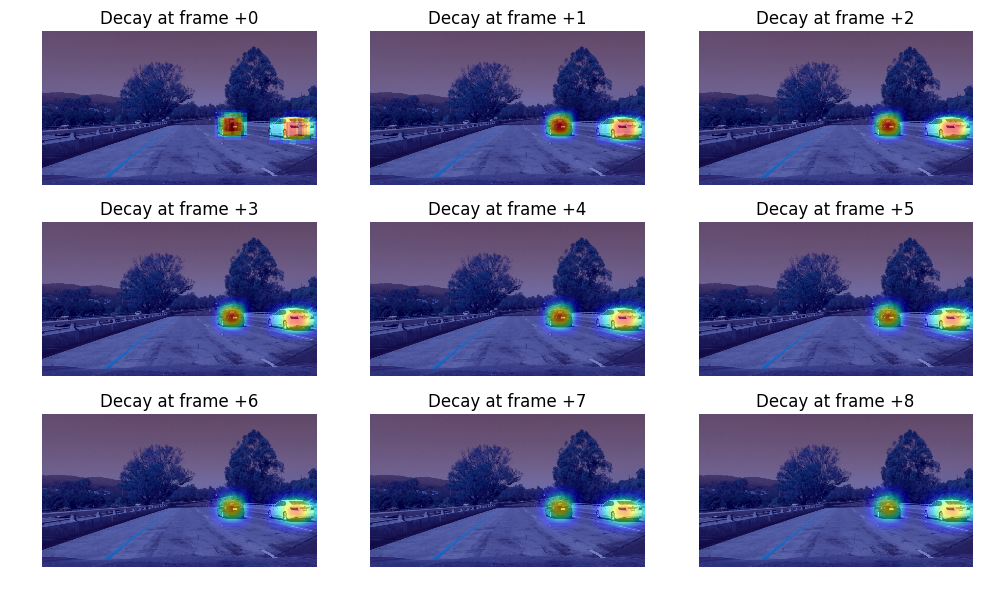

In [36]:
# Heatmap decay
vt.heat_map_threshold = 6
image = cv2.imread('test_images/test1.jpg', 1)
# Scan for cars
car_windows = vt.search_image(image, 2, show_all=False, size_index = -1)
# Generate Heatmap
heatmap = vt.generate_heatmap(image, car_windows)
peak = np.max(heatmap)
# heatmap = heatmap/peak
fig = plt.figure(figsize=(12,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha = 0.5)
    plt.axis('off')
    plt.title("Decay at frame +%i" % i)
    heatmap = cv2.blur(heatmap, (37, 37))
    # maintain same scale by setting pixel to original peak
    heatmap[0,0] = peak
plt.show()